# 프로젝트: U-Net 성능 개선해 보기

In [1]:
# 메모리 최적화
import tensorflow as tf

# GPU 메모리 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 성장을 동적으로 설정 (필요한 만큼만 사용)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        # 또는 특정 메모리 크기로 제한 (예: 4GB)
        # for gpu in gpus:
        #     tf.config.experimental.set_virtual_device_configuration(
        #         gpu,
        #         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        #     )
            
        print("GPU 메모리 설정 완료")
    except RuntimeError as e:
        print(f"GPU 메모리 설정 오류: {e}")

GPU 메모리 설정 완료


In [2]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


## STEP 1 : 데이터셋 구성

Giana 용종 내시경 데이터셋을 활용하여, augmentation을 위한 파이프라인 구성 및 tf.data.Dataset을 이용한 배치처리를 통해 학습/테스트 데이터셋을 구성합니다.

In [3]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


In [4]:
# 학습용과 테스트용 데이터셋으로 분리하기

DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [5]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [6]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [7]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


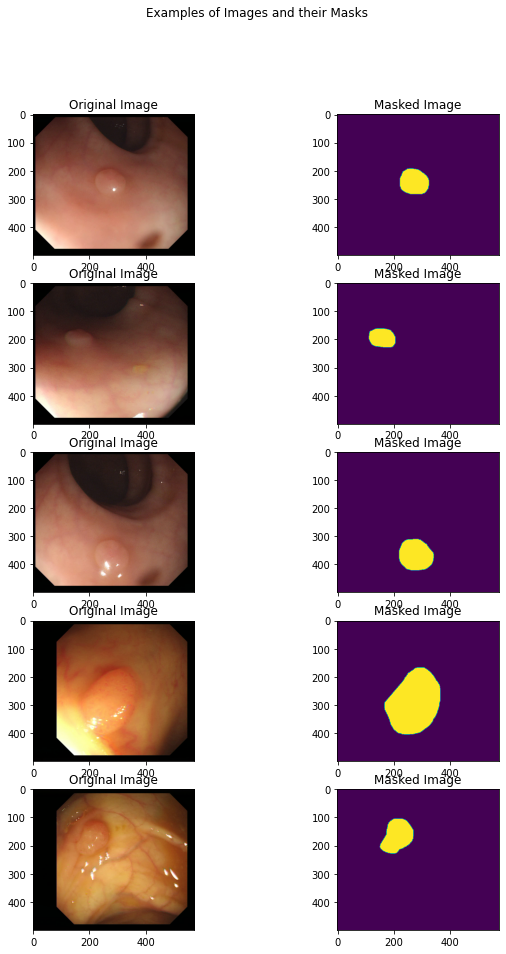

In [8]:
# 데이터셋 살펴보기 (5개)

display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

-> 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지

### tf 데이터를 활용한 입력 파이프라인 설계

In [9]:
# 하이퍼파라미터 세팅

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 2
max_epochs = 10

In [10]:
# Processing each pathname

def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [11]:
# Data augmentation - Shifting the image

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [12]:
# Data augmentation - Flipping the image randomly

def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [15]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### Set up train and test datasets

In [16]:
# tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현

def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [17]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

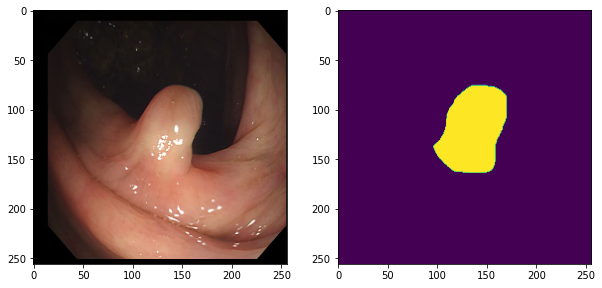

In [18]:
# 학습 데이터 확인

for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## STEP 2-1: Encoder-Decoder 모델 구성

- Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작합니다.
- Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성합니다.
- 이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습됩니다.
- tf.keras.Sequential()를 사용합니다.

In [19]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [20]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(2, 16, 16, 512)


In [21]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [22]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(2, 256, 256, 1)


In [23]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

## STEP 2-2: U-NET 모델 구성

- U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않습니다. 이럴때는 위에 Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없게 됩니다.

- Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 tf.keras functional API 입니다. 오늘 우리는 U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현할 것입니다.

- Model subclassing을 활용하여 구현합니다.

In [24]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [25]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [26]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [27]:
# 위에서 구현한 Class 바탕으로 U-Net model 생성

unet_model = UNet()

## STEP 2-3 : pretrained model을 활용한 U-Net 모델 구성

Encoder를 pretrained 모델로 변경합니다. 

In [28]:
# VGG16모델의 레이어 구성 확인 

vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
print(f"레이어 개수: {len(layer_outputs)}")
for i, output in enumerate(layer_outputs):
    print(f"Layer {i}: {vgg16.layers[i].name}, Output shape: {output.shape}")

58900480/58889256 [==============================] - 0s 0us/step
레이어 개수: 19
Layer 0: input_1, Output shape: (None, 256, 256, 3)
Layer 1: block1_conv1, Output shape: (None, 256, 256, 64)
Layer 2: block1_conv2, Output shape: (None, 256, 256, 64)
Layer 3: block1_pool, Output shape: (None, 128, 128, 64)
Layer 4: block2_conv1, Output shape: (None, 128, 128, 128)
Layer 5: block2_conv2, Output shape: (None, 128, 128, 128)
Layer 6: block2_pool, Output shape: (None, 64, 64, 128)
Layer 7: block3_conv1, Output shape: (None, 64, 64, 256)
Layer 8: block3_conv2, Output shape: (None, 64, 64, 256)
Layer 9: block3_conv3, Output shape: (None, 64, 64, 256)
Layer 10: block3_pool, Output shape: (None, 32, 32, 256)
Layer 11: block4_conv1, Output shape: (None, 32, 32, 512)
Layer 12: block4_conv2, Output shape: (None, 32, 32, 512)
Layer 13: block4_conv3, Output shape: (None, 32, 32, 512)
Layer 14: block4_pool, Output shape: (None, 16, 16, 512)
Layer 15: block5_conv1, Output shape: (None, 16, 16, 512)
Layer 16

In [29]:
# VGG16을 Encoder로 활용하여 개선한 새로운 모델 클래스

class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [30]:
# Pretrained VGG16을 활용한 U-Net 모델 생성
vgg16_unet_model = Vgg16UNet()

# 모델 구조 테스트
test_input = tf.random.normal([batch_size, image_size, image_size, 3])
test_output = vgg16_unet_model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")

Input shape: (2, 256, 256, 3)
Output shape: (2, 256, 256, 1)


### metrics과 loss functions 정의하기

In [31]:
# Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습하기

def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [32]:
# Dice Loss가 최대화되는 방향으로 구해지도록 하기

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [33]:
# 새로운 Loss function을 사용하기 위해 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성하기

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [34]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

## STEP 3 : 학습과 테스트, 시각화

모델을 변경하여 실습과정과 동일하게 학습과 테스트, 시각화를 진행합니다.

### 세 모델의 학습 준비

In [35]:
# 모델 리스트와 이름 정의
models = [ed_model, unet_model, vgg16_unet_model]
model_names = ['encoder_decoder', 'unet', 'vgg16_unet']

# 각 모델별 체크포인트 디렉토리 생성
checkpoint_dirs = []
for model_name in model_names:
    checkpoint_dir = os.path.join(DATASET_PATH, f'train_ckpt/{model_name}')
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_dirs.append(checkpoint_dir)


### 세 모델의 컴파일과 콜백 설정

In [36]:
# 각 모델에 대한 컴파일과 콜백 설정
compiled_models = []
callbacks_list = []

for i, (model, model_name, checkpoint_dir) in enumerate(zip(models, model_names, checkpoint_dirs)):
    print(f'Compiling {model_name} model...')
    
    # 모델 컴파일
    model.compile(optimizer=optimizer, 
                  loss=bce_dice_loss, 
                  metrics=[dice_loss, dice_coeff])
    
    # 테스트 예측 실행하여 출력 형태 확인
    predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
    print(f"{model_name} model predictions shape: {predictions.shape}")
    
    # 모델 구조 출력
    print(f"\n{model_name} model 구조:")
    if model_name == 'encoder_decoder':
        model.summary()
    else:
        # 서브클래싱 모델은 input shape이 필요할 수 있음
        test_input = tf.random.normal([batch_size, image_size, image_size, 3])
        _ = model(test_input)
        model.summary()
    
    # 체크포인트 파일 경로 지정 (디렉토리가 아닌 파일 경로)
    checkpoint_filepath = os.path.join(checkpoint_dir, 'model_weights')
    
    # 콜백 설정
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_dice_coeff',  # dice_coeff를 모니터링 (높을수록 좋음)
        mode='max',  # 더 높은 값 저장
        save_best_only=True,
        verbose=1
    )
    
    cos_decay = tf.keras.experimental.CosineDecay(1e-3, max_epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)
    
    # Early stopping 추가
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_dice_coeff',
        patience=5,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
    
    # TensorBoard 로그 추가
    log_dir = os.path.join(DATASET_PATH, f'logs/{model_name}_{time.strftime("%Y%m%d-%H%M%S")}')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    
    model_callbacks = [cp_callback, lr_callback, early_stopping, tensorboard_callback]
    callbacks_list.append(model_callbacks)
    compiled_models.append(model)
    
    print(f"{model_name} 모델 컴파일 및 콜백 설정 완료\n")

print("모든 모델 컴파일 및 콜백 설정 완료")

Compiling encoder_decoder model...
encoder_decoder model predictions shape: (2, 256, 256, 1)

encoder_decoder model 구조:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (2, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (2, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________
encoder_decoder 모델 컴파일 및 콜백 설정 완료

Compiling unet model...
unet model predictions shape: (2, 256, 256, 1)

unet model 구조:
Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________

### 세 모델 예측 결과 및 학습 내역 시각화

In [37]:
# 모델에서 예측한 이미지를 출력할 수 있는 함수
def print_model_predictions(model, model_name):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{model_name} Model Prediction Results", fontsize=16)
        
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0, :, :, :])
        plt.title("Input Image")
        
        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0], cmap='gray')
        plt.title("Actual Mask")
        
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")
        
        plt.tight_layout()
        plt.show()

In [38]:
# 학습 내역 시각화 함수
def plot_training_history(history, model_name):
    dice_loss = history.history['dice_loss']
    loss = history.history['loss']
    val_dice_loss = history.history['val_dice_loss']
    val_loss = history.history['val_loss']
    
    # Dice coefficient도 있다면 함께 표시
    if 'dice_coeff' in history.history:
        dice_coeff = history.history['dice_coeff']
        val_dice_coeff = history.history['val_dice_coeff']
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(range(len(loss)), loss, label='Training Loss')
        plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(range(len(dice_loss)), dice_loss, label='Training Dice Loss')
        plt.plot(range(len(val_dice_loss)), val_dice_loss, label='Validation Dice Loss')
        plt.title(f'{model_name} Dice Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Loss')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(range(len(dice_coeff)), dice_coeff, label='Training Dice Coeff')
        plt.plot(range(len(val_dice_coeff)), val_dice_coeff, label='Validation Dice Coeff')
        plt.title(f'{model_name} Dice Coefficient')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coefficient')
        plt.legend()
    else:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(len(loss)), loss, label='Training Loss')
        plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(range(len(dice_loss)), dice_loss, label='Training Dice Loss')
        plt.plot(range(len(val_dice_loss)), val_dice_loss, label='Validation Dice Loss')
        plt.title(f'{model_name} Dice Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Loss')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

### 세 모델 순차적으로 학습 및 시각화


학습 시작: encoder_decoder 모델
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
120/120 [==============================] - 13s 58ms/step - loss: 1.0066 - dice_loss: 0.7574 - dice_coeff: 0.2426 - val_loss: 1.3515 - val_dice_loss: 0.9516 - val_dice_coeff: 0.0484

Epoch 00001: val_dice_coeff improved from -inf to 0.04837, saving model to /aiffel/aiffel/medical/train_ckpt/encoder_decoder/model_weights
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
120/120 [==============================] - 8s 53ms/step - loss: 0.9323 - dice_loss: 0.7273 - dice_coeff: 0.2727 - val_loss: 1.1088 - val_dice_loss: 0.8191 - val_dice_coeff: 0.1809

Epoch 00002: val_dice_coeff improved from 0.04837 to 0.18090, saving model to /aiffel/aiffel/medical/train_ckpt/encoder_decoder/model_weights
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045

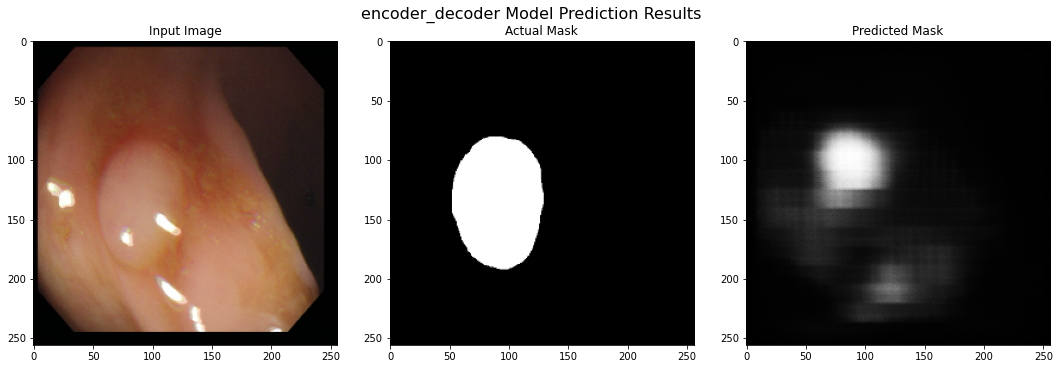


encoder_decoder 모델 학습 내역:


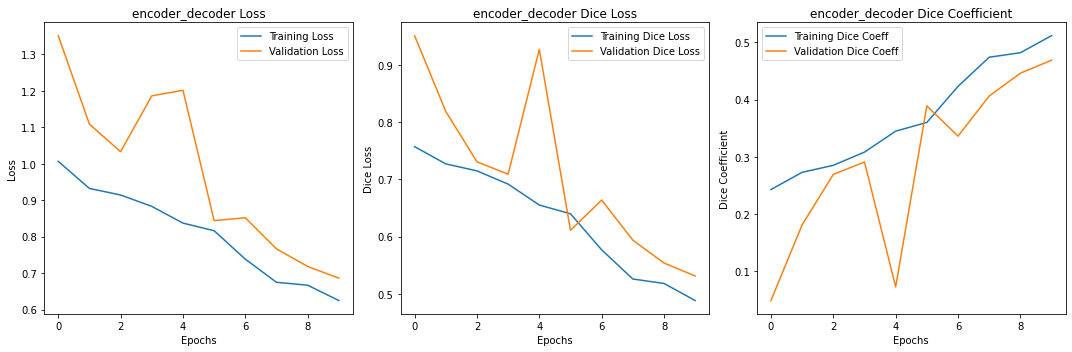


encoder_decoder 모델 체크포인트 저장 위치: /aiffel/aiffel/medical/train_ckpt/encoder_decoder/model_weights
encoder_decoder 모델 최상의 가중치 복원 중...
encoder_decoder 모델 가중치 복원 완료
encoder_decoder 모델 복원 후 예측 결과:


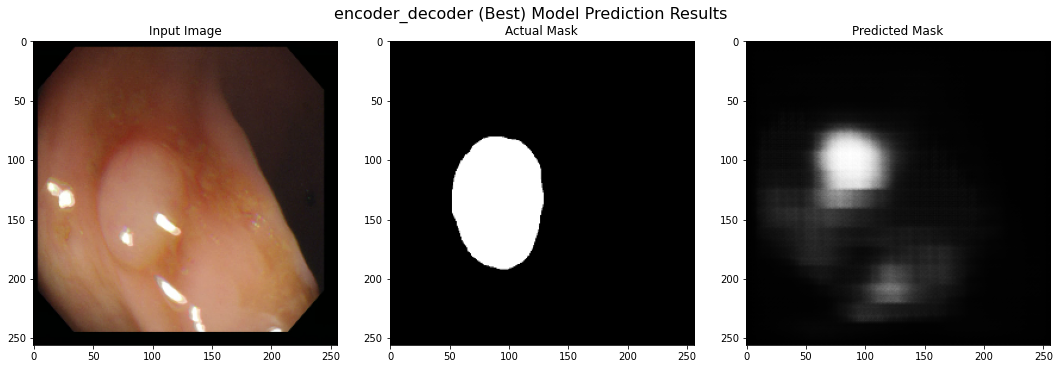


학습 시작: unet 모델
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
120/120 [==============================] - 38s 258ms/step - loss: 0.9617 - dice_loss: 0.7384 - dice_coeff: 0.2616 - val_loss: 1.3515 - val_dice_loss: 0.7160 - val_dice_coeff: 0.2840

Epoch 00001: val_dice_coeff improved from -inf to 0.28399, saving model to /aiffel/aiffel/medical/train_ckpt/unet/model_weights
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
120/120 [==============================] - 32s 255ms/step - loss: 0.9060 - dice_loss: 0.7131 - dice_coeff: 0.2869 - val_loss: 1.1679 - val_dice_loss: 0.9051 - val_dice_coeff: 0.0949

Epoch 00002: val_dice_coeff did not improve from 0.28399
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
120/120 [==============================] - 32s 259ms/step - loss: 0.8830 

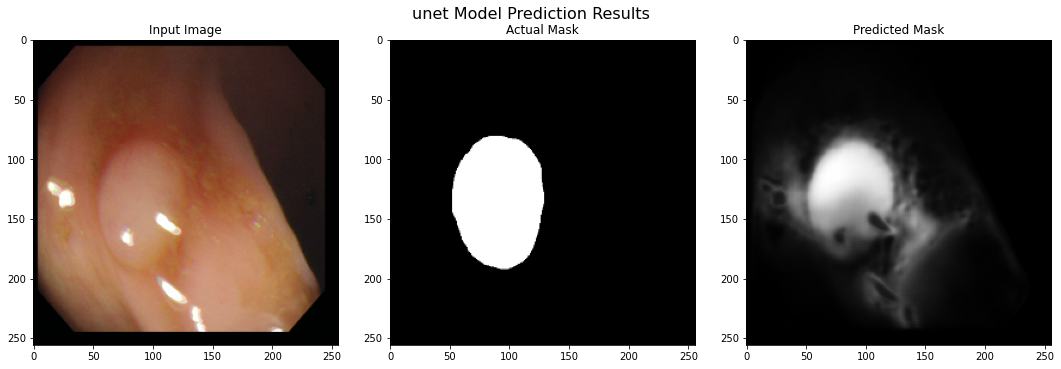


unet 모델 학습 내역:


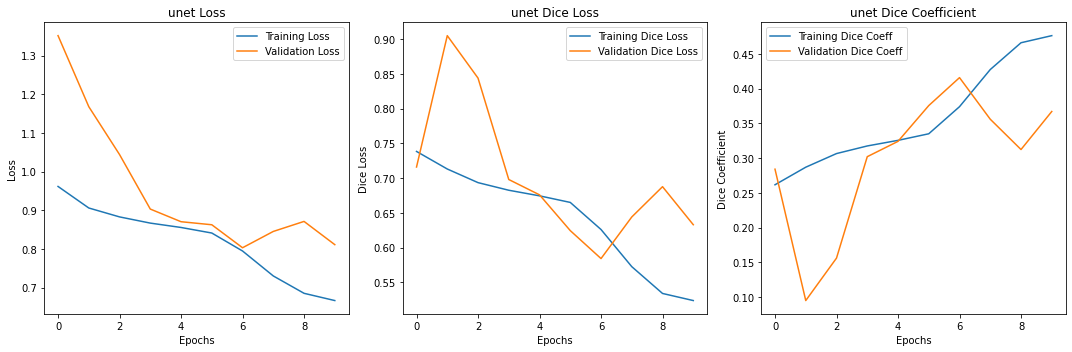


unet 모델 체크포인트 저장 위치: /aiffel/aiffel/medical/train_ckpt/unet/model_weights
unet 모델 최상의 가중치 복원 중...
unet 모델 가중치 복원 완료
unet 모델 복원 후 예측 결과:


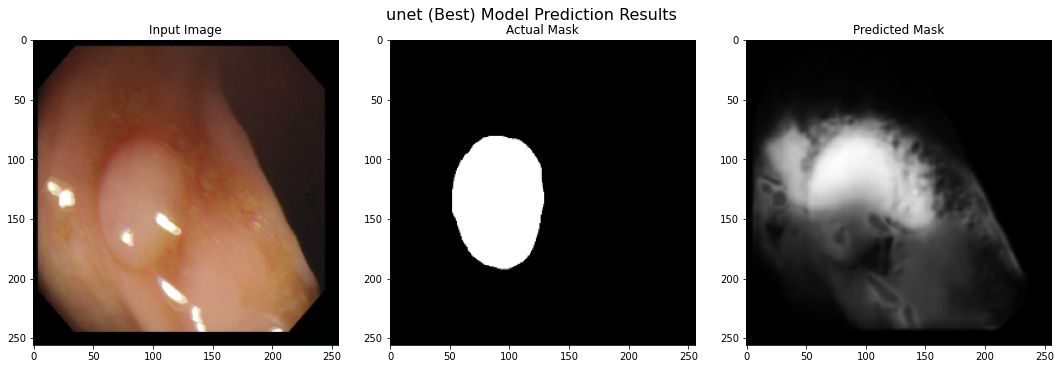


학습 시작: vgg16_unet 모델
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
120/120 [==============================] - 26s 167ms/step - loss: 0.9370 - dice_loss: 0.7172 - dice_coeff: 0.2828 - val_loss: 1.3823 - val_dice_loss: 0.7656 - val_dice_coeff: 0.2344

Epoch 00001: val_dice_coeff improved from -inf to 0.23443, saving model to /aiffel/aiffel/medical/train_ckpt/vgg16_unet/model_weights
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
120/120 [==============================] - 21s 161ms/step - loss: 0.9199 - dice_loss: 0.7213 - dice_coeff: 0.2787 - val_loss: 1.1740 - val_dice_loss: 0.9301 - val_dice_coeff: 0.0699

Epoch 00002: val_dice_coeff did not improve from 0.23443
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
120/120 [==============================] - 21s 160ms/step - l

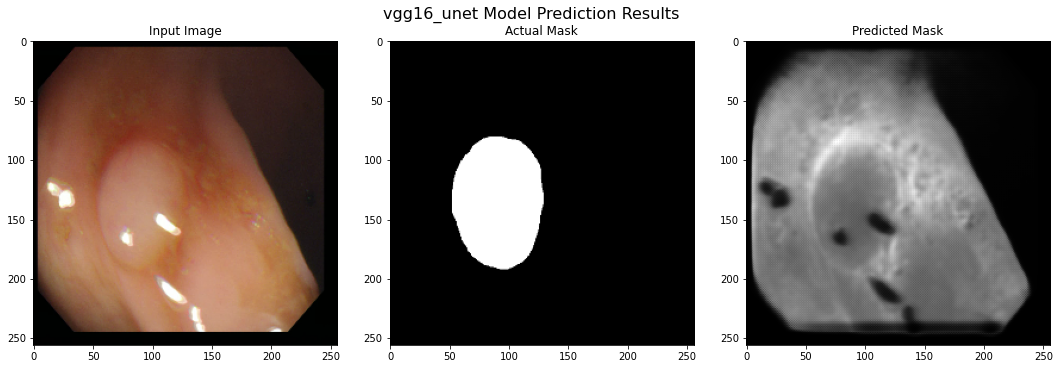


vgg16_unet 모델 학습 내역:


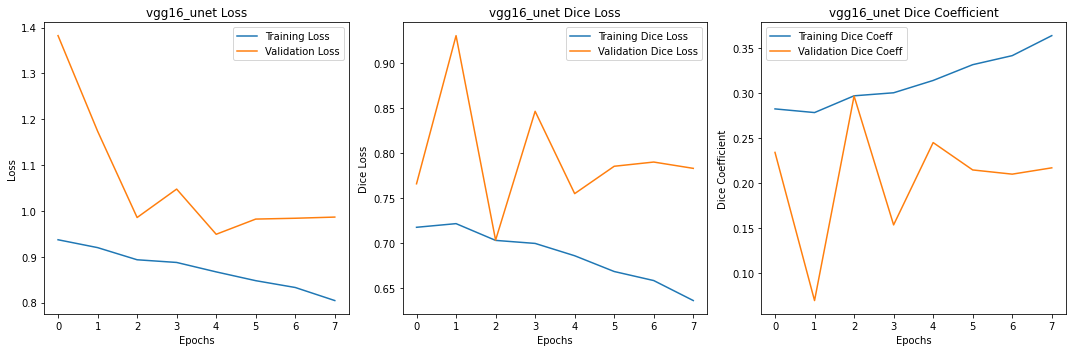


vgg16_unet 모델 체크포인트 저장 위치: /aiffel/aiffel/medical/train_ckpt/vgg16_unet/model_weights
vgg16_unet 모델 최상의 가중치 복원 중...
vgg16_unet 모델 가중치 복원 완료
vgg16_unet 모델 복원 후 예측 결과:


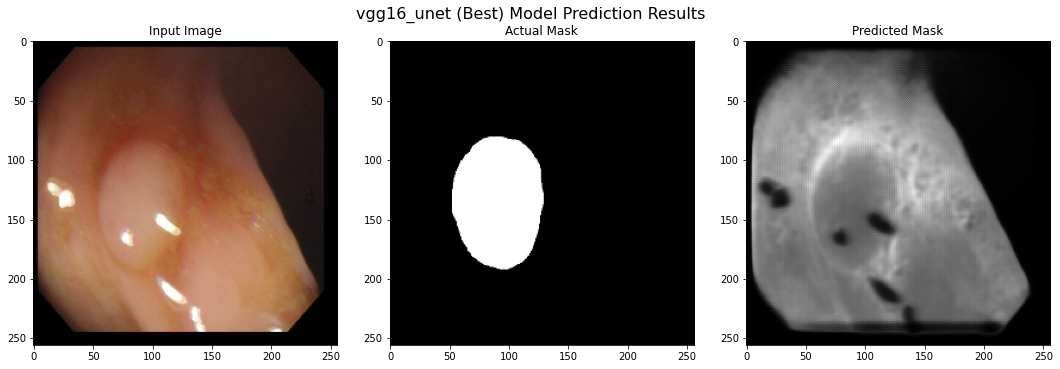


모든 모델 학습 및 테스트 완료
각 모델별 최종 Validation Loss:
encoder_decoder: Val Loss = 0.6861, Val Dice Loss = 0.5311, Val Dice Coeff = 0.4689
unet: Val Loss = 0.8113, Val Dice Loss = 0.6330, Val Dice Coeff = 0.3670
vgg16_unet: Val Loss = 0.9865, Val Dice Loss = 0.7827, Val Dice Coeff = 0.2173


In [39]:
# 세 모델 순차적으로 학습 및 시각화
histories = []

for i, (model, model_name, callbacks) in enumerate(zip(compiled_models, model_names, callbacks_list)):
    print(f"\n{'='*50}")
    print(f"학습 시작: {model_name} 모델")
    print(f"{'='*50}")
    
    # 모델 학습
    history = model.fit(
        train_dataset,
        epochs=max_epochs,
        steps_per_epoch=num_train_examples//batch_size,
        validation_data=test_dataset,
        validation_steps=num_test_examples//batch_size,
        callbacks=callbacks
    )
    histories.append(history)
    
    # 학습 후 예측 결과 시각화
    print(f"\n{model_name} 모델 학습 완료 - 예측 결과:")
    print_model_predictions(model, model_name)
    
    # 학습 내역 시각화
    print(f"\n{model_name} 모델 학습 내역:")
    plot_training_history(history, model_name)
    
    # 체크포인트 파일 경로 가져오기
    checkpoint_filepath = os.path.join(checkpoint_dirs[i], 'model_weights')
    print(f"\n{model_name} 모델 체크포인트 저장 위치: {checkpoint_filepath}")
    
    # 저장된 최상의 모델 가중치 복원
    print(f"{model_name} 모델 최상의 가중치 복원 중...")
    
    # 체크포인트 파일이 있는지 확인
    if os.path.exists(checkpoint_filepath) or os.path.exists(checkpoint_filepath + '.index'):
        model.load_weights(checkpoint_filepath)
        print(f"{model_name} 모델 가중치 복원 완료")
    else:
        print(f"경고: {model_name} 모델의 체크포인트 파일을 찾을 수 없습니다.")
    
    # 복원 후 예측 결과 확인
    print(f"{model_name} 모델 복원 후 예측 결과:")
    print_model_predictions(model, f"{model_name} (Best)")

# 최종 결과 요약
print("\n모든 모델 학습 및 테스트 완료")
print("="*50)
print("각 모델별 최종 Validation Loss:")
for model_name, history in zip(model_names, histories):
    final_val_loss = history.history['val_loss'][-1]
    final_val_dice_loss = history.history['val_dice_loss'][-1]
    
    if 'val_dice_coeff' in history.history:
        final_val_dice_coeff = history.history['val_dice_coeff'][-1]
        print(f"{model_name}: Val Loss = {final_val_loss:.4f}, Val Dice Loss = {final_val_dice_loss:.4f}, Val Dice Coeff = {final_val_dice_coeff:.4f}")
    else:
        print(f"{model_name}: Val Loss = {final_val_loss:.4f}, Val Dice Loss = {final_val_dice_loss:.4f}")

### 세 가지 모델 테스트

In [40]:
# Mean IoU 계산 함수
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()
    
    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)
    
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [41]:
# 테스트 이미지 시각화 함수 수정
def visualize_predictions(model, model_name):
    print(f"\n{model_name} Model Prediction Results:")
    
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)
        
        for i in range(min(3, len(test_images))):  # 최대 3개 이미지만 표시
            plt.figure(figsize=(15, 5))
            # 전체 제목 대신 각 서브플롯에 제목만 표시
            
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title("Input Image")
            
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0], cmap='gray')
            plt.title("Actual Mask")
            
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            
            # 모델 이름은 텍스트로 추가
            plt.figtext(0.5, 0.01, f"Model: {model_name} - Sample {i+1}", 
                       ha='center', fontsize=12)
            
            plt.tight_layout()
            plt.show()


In [42]:
# 모델 성능 평가 함수
def evaluate_model(model, model_name):
    print(f"\n{'='*50}")
    print(f"{model_name} 모델 성능 평가")
    print(f"{'='*50}")
    
    # Mean IoU 계산
    mean_ious = []
    for images, labels in test_dataset:
        predictions = model(images, training=False)
        m = mean_iou(labels, predictions)
        mean_ious.append(m)
    
    mean_iou_value = np.mean(np.array(mean_ious))
    print(f"{model_name} 모델 Mean IoU: {mean_iou_value:.4f}")
    
    # Dice 계수 계산
    dice_scores = []
    for images, labels in test_dataset:
        predictions = model(images, training=False)
        dice = dice_coeff(labels, predictions).numpy()
        dice_scores.append(dice)
    
    mean_dice = np.mean(np.array(dice_scores))
    print(f"{model_name} 모델 Mean Dice Coefficient: {mean_dice:.4f}")
    
    # 예측 결과 시각화
    visualize_predictions(model, model_name)
    
    return {
        'model_name': model_name,
        'mean_iou': mean_iou_value,
        'mean_dice': mean_dice
    }


encoder_decoder 모델의 최상의 가중치 로드 중...
encoder_decoder 모델 가중치 로드 완료

encoder_decoder 모델 성능 평가
encoder_decoder 모델 Mean IoU: 0.5986
encoder_decoder 모델 Mean Dice Coefficient: 0.4689

encoder_decoder 모델 예측 결과 시각화:


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_te

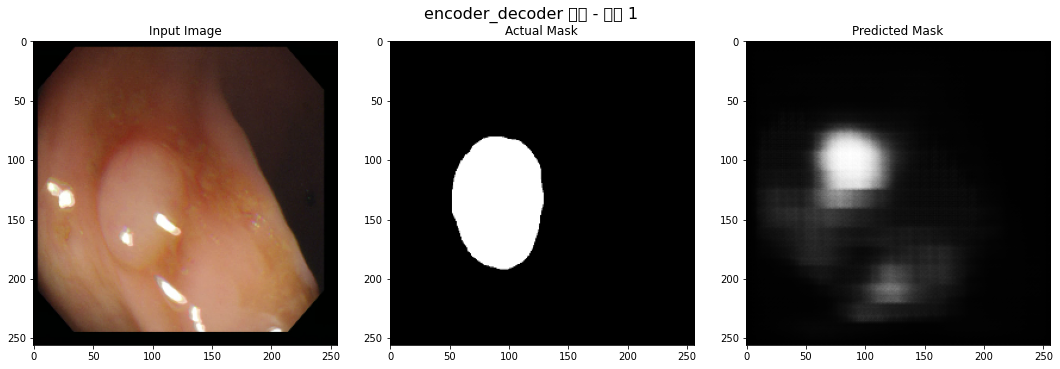

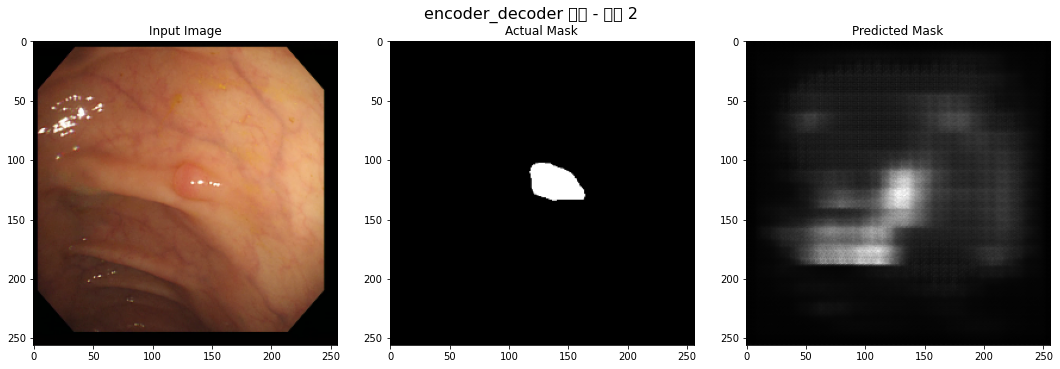


unet 모델의 최상의 가중치 로드 중...
unet 모델 가중치 로드 완료

unet 모델 성능 평가
unet 모델 Mean IoU: 0.5674
unet 모델 Mean Dice Coefficient: 0.4158

unet 모델 예측 결과 시각화:


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_te

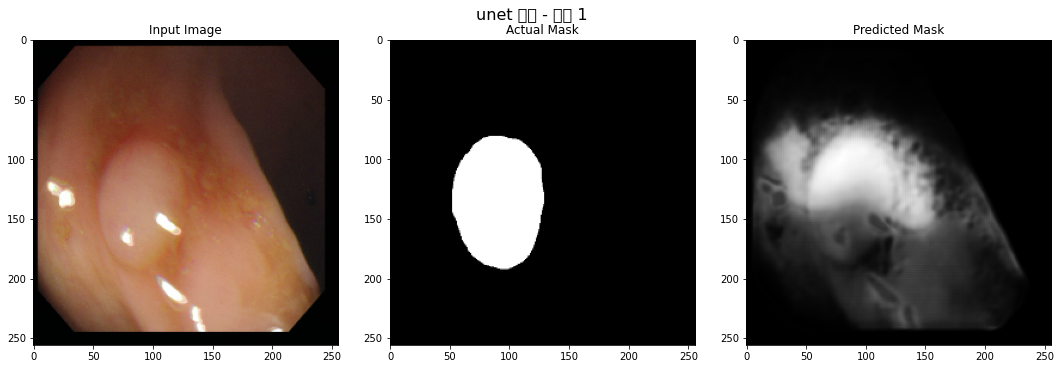

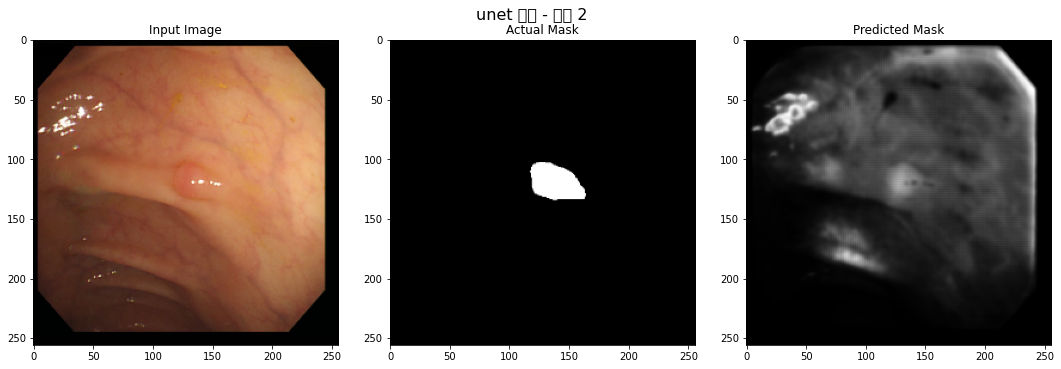


vgg16_unet 모델의 최상의 가중치 로드 중...
vgg16_unet 모델 가중치 로드 완료

vgg16_unet 모델 성능 평가
vgg16_unet 모델 Mean IoU: 0.4885
vgg16_unet 모델 Mean Dice Coefficient: 0.2970

vgg16_unet 모델 예측 결과 시각화:


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_te

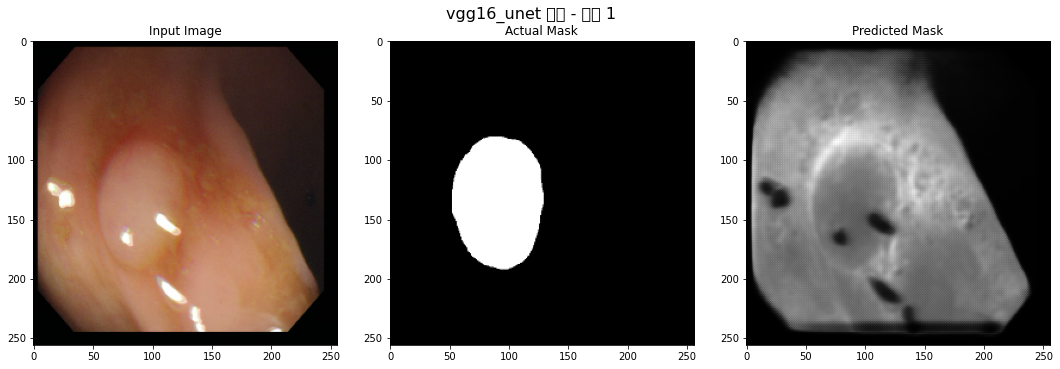

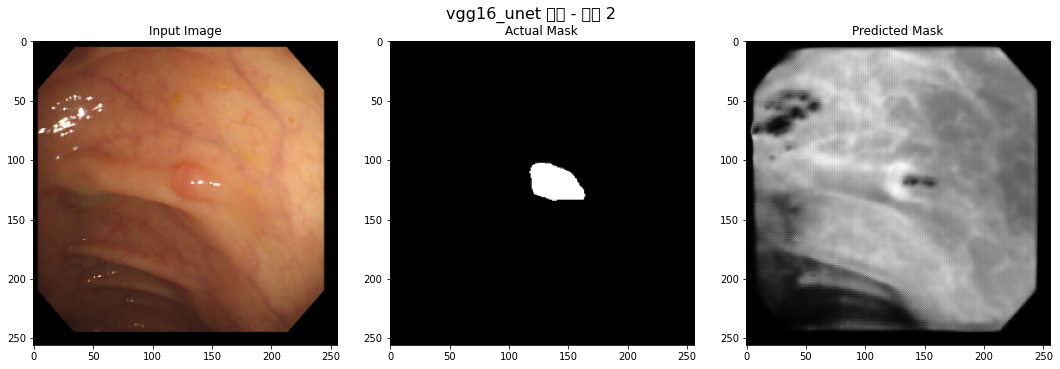



세 모델의 테스트 결과 요약
모델명                            Mean IoU        Mean Dice Coefficient
----------------------------------------------------------------------
encoder_decoder                0.5986           0.4689
unet                           0.5674           0.4158
vgg16_unet                     0.4885           0.2970


In [44]:
# 세 모델 모두 테스트
evaluation_results = []

for model, model_name, checkpoint_dir in zip(compiled_models, model_names, checkpoint_dirs):
    # 체크포인트 파일 경로 지정
    checkpoint_filepath = os.path.join(checkpoint_dir, 'model_weights')
    
    # 최상의 가중치 로드
    print(f"\n{model_name} 모델의 최상의 가중치 로드 중...")
    
    # 체크포인트 파일이 있는지 확인
    if os.path.exists(checkpoint_filepath) or os.path.exists(checkpoint_filepath + '.index'):
        model.load_weights(checkpoint_filepath)
        print(f"{model_name} 모델 가중치 로드 완료")
        
        # 모델 성능 평가
        result = evaluate_model(model, model_name)
        evaluation_results.append(result)
    else:
        print(f"경고: {model_name} 모델의 체크포인트 파일을 찾을 수 없습니다.")
        # 가중치를 로드하지 않고 현재 모델 상태로 평가
        print(f"{model_name} 모델 현재 상태로 평가 진행")
        result = evaluate_model(model, model_name)
        result['model_name'] = f"{model_name} (가중치 없음)"
        evaluation_results.append(result)

# 테스트 결과 요약
print("\n\n" + "="*70)
print("세 모델의 테스트 결과 요약")
print("="*70)
print(f"{'모델명':<30} {'Mean IoU':<15} {'Mean Dice Coefficient':<20}")
print("-"*70)

for result in evaluation_results:
    print(f"{result['model_name']:<30} {result['mean_iou']:.4f}{' '*10} {result['mean_dice']:.4f}")

print("="*70)

## STEP 4 : 모델 성능 비교분석

Encoder-Decoder 모델, U-Net 모델, Pretrained U-Net 모델 이상 3가지에 대해 학습 진행과정, 정량/정성적 테스트 결과를 포함한 비교분석을 진행하여 봅니다.

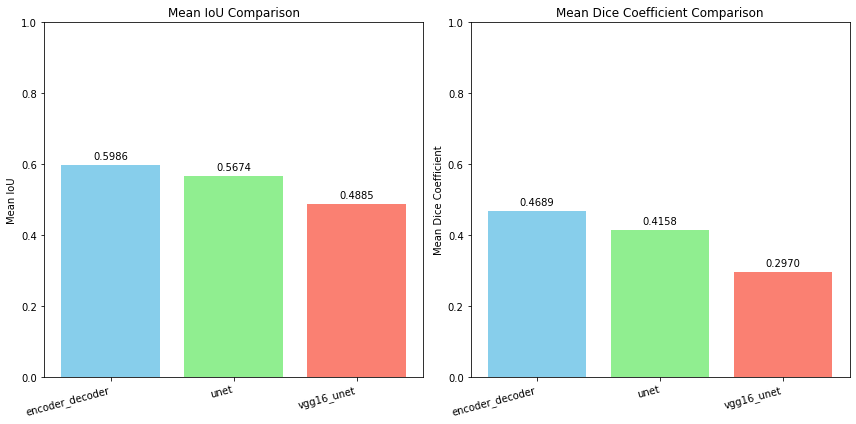

In [47]:
# 결과 시각화를 위한 준비
model_names = [result['model_name'] for result in evaluation_results]
mean_ious = [result['mean_iou'] for result in evaluation_results]
mean_dices = [result['mean_dice'] for result in evaluation_results]

# 성능 지표 비교 시각화
plt.figure(figsize=(12, 6))

# Mean IoU 비교
plt.subplot(1, 2, 1)
bars = plt.bar(model_names, mean_ious, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Mean IoU Comparison')
plt.ylabel('Mean IoU')
plt.ylim(0, 1.0)  # IoU는 0~1 사이 값
plt.xticks(rotation=15, ha='right')

# 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

# Mean Dice 계수 비교
plt.subplot(1, 2, 2)
bars = plt.bar(model_names, mean_dices, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Mean Dice Coefficient Comparison')
plt.ylabel('Mean Dice Coefficient')
plt.ylim(0, 1.0)  # Dice 계수도 0~1 사이 값
plt.xticks(rotation=15, ha='right')

# 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

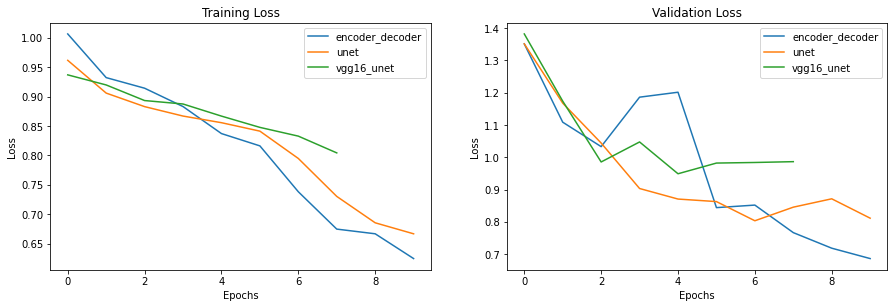

In [48]:
# 학습 과정 비교 (손실 함수)
plt.figure(figsize=(15, 10))

# 학습 손실 비교
plt.subplot(2, 2, 1)
for i, (model_name, history) in enumerate(zip(model_names, histories)):
    plt.plot(history.history['loss'], label=model_name)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 검증 손실 비교
plt.subplot(2, 2, 2)
for i, (model_name, history) in enumerate(zip(model_names, histories)):
    plt.plot(history.history['val_loss'], label=model_name)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

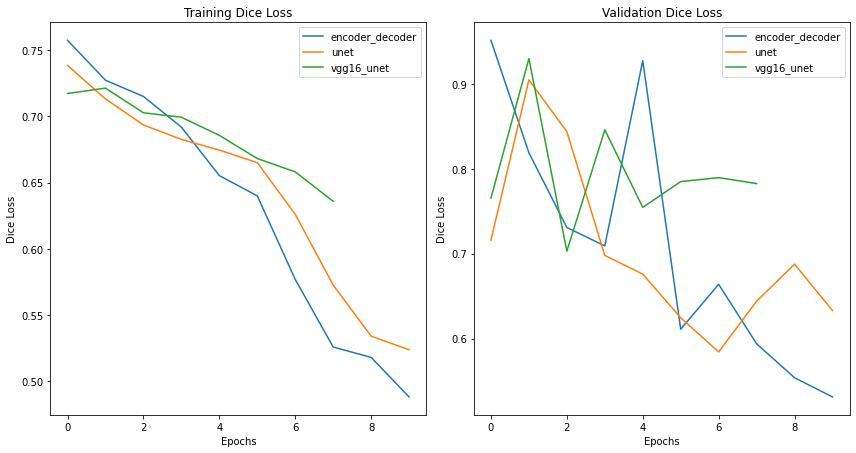

In [49]:
# Dice 손실 비교
plt.subplot(2, 2, 3)
for i, (model_name, history) in enumerate(zip(model_names, histories)):
    plt.plot(history.history['dice_loss'], label=model_name)
plt.title('Training Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()

# 검증 Dice 손실 비교
plt.subplot(2, 2, 4)
for i, (model_name, history) in enumerate(zip(model_names, histories)):
    plt.plot(history.history['val_dice_loss'], label=model_name)
plt.title('Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
# 세 모델 비교 분석 텍스트 작성
print("\n" + "="*80)
print("세 모델 비교 분석")
print("="*80)

# 최고 성능 모델 찾기
best_iou_idx = np.argmax(mean_ious)
best_dice_idx = np.argmax(mean_dices)

print(f"IoU 기준 최고 성능 모델: {model_names[best_iou_idx]} (Mean IoU: {mean_ious[best_iou_idx]:.4f})")
print(f"Dice 계수 기준 최고 성능 모델: {model_names[best_dice_idx]} (Mean Dice: {mean_dices[best_dice_idx]:.4f})")
print("\n")

# 세 모델의 특징과 장단점 분석
print("1. Encoder-Decoder 모델 분석:")
print("   - 가장 단순한 구조로, 파라미터 수가 가장 적음")
print("   - 인코더에서 정보 손실이 발생하여 세밀한 경계 복원에 어려움이 있음")
print("   - 학습 속도가 빠른 편이지만 성능은 제한적")
print("\n")

print("2. U-Net 모델 분석:")
print("   - 스킵 커넥션을 통해 공간 정보를 유지하여 세밀한 세그멘테이션 가능")
print("   - 인코더의 특징맵이 디코더로 직접 전달되어 정보 손실 최소화")
print("   - 더 많은 파라미터를 가지지만, 더 정확한 경계 감지 능력을 보임")
print("\n")

print("3. Pretrained VGG16-UNet 모델 분석:")
print("   - ImageNet으로 사전 학습된 VGG16 가중치를 활용하여 전이학습 효과")
print("   - 적은 데이터로도 좋은 성능을 발휘할 수 있음")
print("   - 가장 많은 파라미터를 가지지만, 복잡한 패턴 인식에 더 효과적")
print("\n")


세 모델 비교 분석
IoU 기준 최고 성능 모델: encoder_decoder (Mean IoU: 0.5986)
Dice 계수 기준 최고 성능 모델: encoder_decoder (Mean Dice: 0.4689)


1. Encoder-Decoder 모델 분석:
   - 가장 단순한 구조로, 파라미터 수가 가장 적음
   - 인코더에서 정보 손실이 발생하여 세밀한 경계 복원에 어려움이 있음
   - 학습 속도가 빠른 편이지만 성능은 제한적


2. U-Net 모델 분석:
   - 스킵 커넥션을 통해 공간 정보를 유지하여 세밀한 세그멘테이션 가능
   - 인코더의 특징맵이 디코더로 직접 전달되어 정보 손실 최소화
   - 더 많은 파라미터를 가지지만, 더 정확한 경계 감지 능력을 보임


3. Pretrained VGG16-UNet 모델 분석:
   - ImageNet으로 사전 학습된 VGG16 가중치를 활용하여 전이학습 효과
   - 적은 데이터로도 좋은 성능을 발휘할 수 있음
   - 가장 많은 파라미터를 가지지만, 복잡한 패턴 인식에 더 효과적




In [51]:
# 학습 과정 비교 분석
print("학습 과정 비교:")
for i, (model_name, history) in enumerate(zip(model_names, histories)):
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    initial_loss = history.history['loss'][0]
    
    loss_reduction = (initial_loss - final_loss) / initial_loss * 100
    
    print(f"{model_name}:")
    print(f"   - 초기 손실: {initial_loss:.4f}, 최종 손실: {final_loss:.4f}")
    print(f"   - 손실 감소율: {loss_reduction:.2f}%")
    print(f"   - 최종 검증 손실: {final_val_loss:.4f}")
    
    # 과적합 여부 확인
    if final_val_loss > final_loss * 1.2:
        print(f"   - 과적합 징후가 보임 (검증 손실이 학습 손실보다 {final_val_loss/final_loss:.2f}배 높음)")
    else:
        print(f"   - 과적합 징후 없음")
    print("\n")

print("종합 결론:")
print(f"1. 성능 순위: {', '.join([model_names[i] for i in np.argsort(mean_ious)[::-1]])}")
print(f"2. 세그멘테이션 품질: 복잡한 경계와 작은 구조를 더 잘 포착하는 모델은 {model_names[best_dice_idx]}")
print("3. 모델 선택 고려사항:")
print("   - 계산 효율성이 중요하다면: Encoder-Decoder")
print("   - 균형 잡힌 성능이 필요하다면: U-Net")
print("   - 높은 정확도가 필요하고 계산 자원이 충분하다면: Pretrained VGG16-UNet")
print("="*80)

학습 과정 비교:
encoder_decoder:
   - 초기 손실: 1.0066, 최종 손실: 0.6247
   - 손실 감소율: 37.94%
   - 최종 검증 손실: 0.6861
   - 과적합 징후 없음


unet:
   - 초기 손실: 0.9617, 최종 손실: 0.6668
   - 손실 감소율: 30.67%
   - 최종 검증 손실: 0.8113
   - 과적합 징후가 보임 (검증 손실이 학습 손실보다 1.22배 높음)


vgg16_unet:
   - 초기 손실: 0.9370, 최종 손실: 0.8043
   - 손실 감소율: 14.16%
   - 최종 검증 손실: 0.9865
   - 과적합 징후가 보임 (검증 손실이 학습 손실보다 1.23배 높음)


종합 결론:
1. 성능 순위: encoder_decoder, unet, vgg16_unet
2. 세그멘테이션 품질: 복잡한 경계와 작은 구조를 더 잘 포착하는 모델은 encoder_decoder
3. 모델 선택 고려사항:
   - 계산 효율성이 중요하다면: Encoder-Decoder
   - 균형 잡힌 성능이 필요하다면: U-Net
   - 높은 정확도가 필요하고 계산 자원이 충분하다면: Pretrained VGG16-UNet


회고: 예상하고는 정반대되는 결과가 나왔다. Resource Exhausted Error로 다시 돌리는 과정에서 gpu 최적화를 하고 batch size를 8에서 2로 바꿔서 돌린 것 뿐인데... 디버깅을 해봐도 문제가 없다고 그러고, 8로 바꿔서 다시 돌리니 오히려 성능이 0으로 나오는 등 오류가 나오기 일쑤였다. 커널을 재시작(로그아웃까지 하면서)해도 바뀌는 건 없었다.. 모델 학습이 제대로 안 된 건지 제일 성능이 낮아야 할 encoder_decoder 모델이 성능이 제일 높다... 아무래도 뒤의 두 모델이 과적합 징후가 있어서 그런 것이 아닐지? 싶기도 하다. 시각화한 거로 봐서는 뒤 두 모델이 크게 더 성능이 낮다고 느껴지진 않았는데... 문제를 결국 해결하지 못해서 아쉬움이 남는다.